# GARCH

Financial asset returns exhibit volatility clustering (also called volaltility regimes), as well as mean reversion.  This means that high volatility periods beget high volatility periods, low volaility periods beget low volatility periods, and that volatility doesn't diverge to either infinity or zero.  Garch (generalized autoregressive conditional heteroskedasticity) time series models are popular for capturing these characteristics.

This notebook demonstrates code that implements a Garch(1, 1) model using the `arch` package.  In the spirit of machine learning, we will view garch as a volatility prediction mechanism, and our interest will be on empirically determining the performace of garch relative to other prediction techniques (this is what you will do in your homework).

In this notebook we will be focused exclusively on implementation, and thus we won't be digging into the mathematical or statistical details of Garch models - if you are interested, check out the references at the end.  In particular, we will generate some garch forcasts of SPY weekly volatility for the backtest period 1/1/2005 - 3/30/2016, and see how our results comparte Sepp 2016 (*Volatility Modeling and Trading*).

## Loading Packages

We begin by loading the packages and functions that we will need.

In [1]:
from arch import arch_model
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import sys
pd.options.display.max_rows = 10

## SPY Data for Backtest Period

Next, let's read-in the data for the backtest period. 

In [2]:
df_spy = pdr.get_data_yahoo('SPY', start = '2004-12-31', end = '2016-04-02').reset_index()
df_spy.columns = df_spy.columns.str.lower().str.replace(' ', '_')
df_spy.rename(columns = {'date':'trade_date'}, inplace = True)
df_spy.insert(0, 'ticker', 'SPY')
df_spy

ticker trade_date        high         low        open       close  \
0       SPY 2004-12-31  121.660004  120.800003  121.300003  120.870003   
1       SPY 2005-01-03  121.760002  119.900002  121.559998  120.300003   
2       SPY 2005-01-04  120.540001  118.440002  120.459999  118.830002   
3       SPY 2005-01-05  119.250000  118.000000  118.739998  118.010002   
4       SPY 2005-01-06  119.150002  118.260002  118.440002  118.610001   
...     ...        ...         ...         ...         ...         ...   
2827    SPY 2016-03-28  203.860001  202.710007  203.610001  203.240005   
2828    SPY 2016-03-29  205.250000  202.399994  202.759995  205.119995   
2829    SPY 2016-03-30  206.869995  205.589996  206.300003  206.020004   
2830    SPY 2016-03-31  206.410004  205.330002  205.910004  205.520004   
2831    SPY 2016-04-01  207.139999  203.979996  204.350006  206.919998   

           volume   adj_close  
0      28648800.0   88.953049  
1      55748000.0   88.533607  
2      69167600.0   87.451752  
3      65667300.0   86.848251  
4      47814700.0   87.289810  
...           ...         ...  
2827   62408200.0  187.840271  
2828   92922900.0  189.577805  
2829   86365300.0  190.409622  
2830   94584100.0  189.947510  
2831  114423500.0  191.241440  

[2832 rows x 8 columns]

We will need the daily log returns, so let's calculate those now.

In [3]:
df_spy['dly_ret'] = np.log(df_spy['adj_close']).diff()
df_spy = df_spy.dropna().reset_index(drop = True)
df_spy

ticker trade_date        high         low        open       close  \
0       SPY 2005-01-03  121.760002  119.900002  121.559998  120.300003   
1       SPY 2005-01-04  120.540001  118.440002  120.459999  118.830002   
2       SPY 2005-01-05  119.250000  118.000000  118.739998  118.010002   
3       SPY 2005-01-06  119.150002  118.260002  118.440002  118.610001   
4       SPY 2005-01-07  119.230003  118.129997  118.970001  118.440002   
...     ...        ...         ...         ...         ...         ...   
2826    SPY 2016-03-28  203.860001  202.710007  203.610001  203.240005   
2827    SPY 2016-03-29  205.250000  202.399994  202.759995  205.119995   
2828    SPY 2016-03-30  206.869995  205.589996  206.300003  206.020004   
2829    SPY 2016-03-31  206.410004  205.330002  205.910004  205.520004   
2830    SPY 2016-04-01  207.139999  203.979996  204.350006  206.919998   

           volume   adj_close   dly_ret  
0      55748000.0   88.533607 -0.004726  
1      69167600.0   87.451752 -0.012295  
2      65667300.0   86.848251 -0.006925  
3      47814700.0   87.289810  0.005071  
4      55847700.0   87.164726 -0.001434  
...           ...         ...       ...  
2826   62408200.0  187.840271  0.000590  
2827   92922900.0  189.577805  0.009208  
2828   86365300.0  190.409622  0.004378  
2829   94584100.0  189.947510 -0.002430  
2830  114423500.0  191.241440  0.006789  

[2831 rows x 9 columns]

## Organizing Dates

Let's organize our backtest period into weeks (Monday - Friday), since our analysis is of weekly volatility predictions.

In [4]:
# adding a new columns consisting of the weekday number for each trade_date 
ser_weekday = df_spy['trade_date'].dt.weekday

# assigning a week number to each trade-date; M-F is all the same week
lst_week_num = []
ix_week = 0
lst_week_num.append(ix_week)
for ix in range(0, len(ser_weekday) - 1):
    prev_day = ser_weekday.iloc[ix]
    curr_day = ser_weekday.iloc[ix + 1]
    if curr_day < prev_day:
        ix_week = ix_week + 1
    lst_week_num.append(ix_week)

# inserting the week-number column into df_spy
df_spy.insert(2, 'week_num', lst_week_num)
df_spy

ticker trade_date  week_num        high         low        open  \
0       SPY 2005-01-03         0  121.760002  119.900002  121.559998   
1       SPY 2005-01-04         0  120.540001  118.440002  120.459999   
2       SPY 2005-01-05         0  119.250000  118.000000  118.739998   
3       SPY 2005-01-06         0  119.150002  118.260002  118.440002   
4       SPY 2005-01-07         0  119.230003  118.129997  118.970001   
...     ...        ...       ...         ...         ...         ...   
2826    SPY 2016-03-28       586  203.860001  202.710007  203.610001   
2827    SPY 2016-03-29       586  205.250000  202.399994  202.759995   
2828    SPY 2016-03-30       586  206.869995  205.589996  206.300003   
2829    SPY 2016-03-31       586  206.410004  205.330002  205.910004   
2830    SPY 2016-04-01       586  207.139999  203.979996  204.350006   

           close       volume   adj_close   dly_ret  
0     120.300003   55748000.0   88.533607 -0.004726  
1     118.830002   69167600.0   87.451752 -0.012295  
2     118.010002   65667300.0   86.848251 -0.006925  
3     118.610001   47814700.0   87.289810  0.005071  
4     118.440002   55847700.0   87.164726 -0.001434  
...          ...          ...         ...       ...  
2826  203.240005   62408200.0  187.840271  0.000590  
2827  205.119995   92922900.0  189.577805  0.009208  
2828  206.020004   86365300.0  190.409622  0.004378  
2829  205.520004   94584100.0  189.947510 -0.002430  
2830  206.919998  114423500.0  191.241440  0.006789  

[2831 rows x 10 columns]

The following code generates a `DataFrame` that contains the start-date and end-date for each week.

In [5]:
df_start_end = \
    (
    df_spy.groupby(['week_num'], as_index = False)[['trade_date']].agg([min, max])['trade_date']
    .rename(columns = {'min':'week_start', 'max':'week_end'})
    .reset_index()
    .rename(columns = {'index':'week_num'})
    )
df_start_end

week_num week_start   week_end
0           0 2005-01-03 2005-01-07
1           1 2005-01-10 2005-01-14
2           2 2005-01-18 2005-01-21
3           3 2005-01-24 2005-01-28
4           4 2005-01-31 2005-02-04
..        ...        ...        ...
582       582 2016-02-29 2016-03-04
583       583 2016-03-07 2016-03-11
584       584 2016-03-14 2016-03-18
585       585 2016-03-21 2016-03-24
586       586 2016-03-28 2016-04-01

[587 rows x 3 columns]

And finally let's join the weekly start/end dates into `df_spy`.

In [6]:
df_spy = df_spy.merge(df_start_end)
df_spy

ticker trade_date  week_num        high         low        open  \
0       SPY 2005-01-03         0  121.760002  119.900002  121.559998   
1       SPY 2005-01-04         0  120.540001  118.440002  120.459999   
2       SPY 2005-01-05         0  119.250000  118.000000  118.739998   
3       SPY 2005-01-06         0  119.150002  118.260002  118.440002   
4       SPY 2005-01-07         0  119.230003  118.129997  118.970001   
...     ...        ...       ...         ...         ...         ...   
2826    SPY 2016-03-28       586  203.860001  202.710007  203.610001   
2827    SPY 2016-03-29       586  205.250000  202.399994  202.759995   
2828    SPY 2016-03-30       586  206.869995  205.589996  206.300003   
2829    SPY 2016-03-31       586  206.410004  205.330002  205.910004   
2830    SPY 2016-04-01       586  207.139999  203.979996  204.350006   

           close       volume   adj_close   dly_ret week_start   week_end  
0     120.300003   55748000.0   88.533607 -0.004726 2005-01-03 2005-01-07  
1     118.830002   69167600.0   87.451752 -0.012295 2005-01-03 2005-01-07  
2     118.010002   65667300.0   86.848251 -0.006925 2005-01-03 2005-01-07  
3     118.610001   47814700.0   87.289810  0.005071 2005-01-03 2005-01-07  
4     118.440002   55847700.0   87.164726 -0.001434 2005-01-03 2005-01-07  
...          ...          ...         ...       ...        ...        ...  
2826  203.240005   62408200.0  187.840271  0.000590 2016-03-28 2016-04-01  
2827  205.119995   92922900.0  189.577805  0.009208 2016-03-28 2016-04-01  
2828  206.020004   86365300.0  190.409622  0.004378 2016-03-28 2016-04-01  
2829  205.520004   94584100.0  189.947510 -0.002430 2016-03-28 2016-04-01  
2830  206.919998  114423500.0  191.241440  0.006789 2016-03-28 2016-04-01  

[2831 rows x 12 columns]

## Calculating Realized Volatility

This code cell calculates the realized volatility for each week.  In machine learning parlance, these are the labels that we are trying to predict.

In [7]:
df_realized = \
    (
    df_spy
        .groupby(['week_num', 'week_start', 'week_end'], as_index = False)[['dly_ret']].agg(lambda x: np.std(x) * np.sqrt(252))
        .rename(columns = {'dly_ret':'realized_vol'})
    )
df_realized = df_realized[1:]
df_realized

week_num week_start   week_end  realized_vol
1           1 2005-01-10 2005-01-14      0.093296
2           2 2005-01-18 2005-01-21      0.126561
3           3 2005-01-24 2005-01-28      0.029754
4           4 2005-01-31 2005-02-04      0.069582
5           5 2005-02-07 2005-02-11      0.084567
..        ...        ...        ...           ...
582       582 2016-02-29 2016-03-04      0.159054
583       583 2016-03-07 2016-03-11      0.137591
584       584 2016-03-14 2016-03-18      0.054367
585       585 2016-03-21 2016-03-24      0.048135
586       586 2016-03-28 2016-04-01      0.066438

[586 rows x 4 columns]

## Garch Training Data

A practical rule of thumb for fitting garch models to equity index returns is that you should use 5-10 years worth of data.  In this tutorial we will use 10-years worth.

Let's begin by grabbing all the data that we will need for fitting.

In [8]:
df_train = pdr.get_data_yahoo('SPY', start = '1994-12-30', end = '2016-04-02').reset_index()
df_train.columns = df_train.columns.str.lower().str.replace(' ', '_')
df_train.rename(columns = {'date':'trade_date'}, inplace = True)
df_train.insert(0, 'ticker', 'SPY')
df_train

ticker trade_date        high         low        open       close  \
0       SPY 1994-12-30   46.250000   45.562500   46.203125   45.562500   
1       SPY 1995-01-03   45.843750   45.687500   45.703125   45.781250   
2       SPY 1995-01-04   46.000000   45.750000   45.984375   46.000000   
3       SPY 1995-01-05   46.109375   45.953125   46.031250   46.000000   
4       SPY 1995-01-06   46.250000   45.906250   46.093750   46.046875   
...     ...        ...         ...         ...         ...         ...   
5346    SPY 2016-03-28  203.860001  202.710007  203.610001  203.240005   
5347    SPY 2016-03-29  205.250000  202.399994  202.759995  205.119995   
5348    SPY 2016-03-30  206.869995  205.589996  206.300003  206.020004   
5349    SPY 2016-03-31  206.410004  205.330002  205.910004  205.520004   
5350    SPY 2016-04-01  207.139999  203.979996  204.350006  206.919998   

           volume   adj_close  
0       2209500.0   28.703310  
1        324300.0   28.841124  
2        351800.0   28.978922  
3         89800.0   28.978922  
4        448400.0   29.008436  
...           ...         ...  
5346   62408200.0  187.840271  
5347   92922900.0  189.577805  
5348   86365300.0  190.409622  
5349   94584100.0  189.947510  
5350  114423500.0  191.241440  

[5351 rows x 8 columns]

Next we calculate the daily returns.

In [9]:
df_train['dly_ret'] = np.log(df_train['adj_close']).diff()
df_train.dropna(inplace = True)
df_train.reset_index(drop = True, inplace = True)
df_train

ticker trade_date        high         low        open       close  \
0       SPY 1995-01-03   45.843750   45.687500   45.703125   45.781250   
1       SPY 1995-01-04   46.000000   45.750000   45.984375   46.000000   
2       SPY 1995-01-05   46.109375   45.953125   46.031250   46.000000   
3       SPY 1995-01-06   46.250000   45.906250   46.093750   46.046875   
4       SPY 1995-01-09   46.093750   46.000000   46.031250   46.093750   
...     ...        ...         ...         ...         ...         ...   
5345    SPY 2016-03-28  203.860001  202.710007  203.610001  203.240005   
5346    SPY 2016-03-29  205.250000  202.399994  202.759995  205.119995   
5347    SPY 2016-03-30  206.869995  205.589996  206.300003  206.020004   
5348    SPY 2016-03-31  206.410004  205.330002  205.910004  205.520004   
5349    SPY 2016-04-01  207.139999  203.979996  204.350006  206.919998   

           volume   adj_close   dly_ret  
0        324300.0   28.841124  0.004790  
1        351800.0   28.978922  0.004766  
2         89800.0   28.978922  0.000000  
3        448400.0   29.008436  0.001018  
4         36800.0   29.038006  0.001019  
...           ...         ...       ...  
5345   62408200.0  187.840271  0.000590  
5346   92922900.0  189.577805  0.009208  
5347   86365300.0  190.409622  0.004378  
5348   94584100.0  189.947510 -0.002430  
5349  114423500.0  191.241440  0.006789  

[5350 rows x 9 columns]

The garch fitting process has better convergence if we express the returns as percents rather than decimals.

In [10]:
ser_returns = df_train['dly_ret'] * 100
ser_returns.index = df_train['trade_date']

Next, we instantiate the model.

In [11]:
model = arch_model(ser_returns, vol = 'Garch', p = 1, o = 0, q = 1, dist = 'Normal')
result = model.fit(update_freq = 5)

Iteration:      5,   Func. Count:     41,   Neg. LLF: 7601.62327486168
Iteration:     10,   Func. Count:     74,   Neg. LLF: 7598.337834025585
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7598.334319746626
            Iterations: 12
            Function evaluations: 87
            Gradient evaluations: 12


The following code loops through ane performs the fitting for each day.  It take a while to run, so I'll leave it to you to run and examine on your own time.  See the package documentation linked below for details - you will probably need to read these in order to complete your project.

In [12]:
# ix_start = df_train.query('trade_date == trade_date.min()').index[0]
# ix_end = df_train.query('trade_date == "2004-12-31"').index[0]
# forecasts = {}
# for ix in range(2518, 5349):
#     sys.stdout.write('.')
#     sys.stdout.flush()
#     result = model.fit(first_obs = (ix - 2518), last_obs = ix, disp = 'off')
#     temp = result.forecast(horizon = 5).variance
#     fcast = temp.iloc[ix - 1]
#     forecasts[fcast.name] = fcast
# print()
# df_forecast = pd.DataFrame(pd.DataFrame(forecasts).T)
# df_forecast = df_forecast.reset_index().rename(columns = {'index':'trade_date'})
# df_forecast

# writing variance estimates to csv-file
# df_forecast.to_csv('variance_forecast.csv', index = False)

The above code saves the variance estimates to a CSV file, and we will read those in now.

In [13]:
df_forecast = pd.read_csv('variance_forecast.csv')
df_forecast['trade_date'] = pd.to_datetime(df_forecast['trade_date'])
df_forecast

trade_date       h.1       h.2       h.3       h.4       h.5
0    2004-12-30  0.312158  0.320806  0.329422  0.338007  0.346559
1    2004-12-31  0.303720  0.312431  0.321110  0.329757  0.338371
2    2005-01-03  0.313480  0.322233  0.330952  0.339638  0.348290
3    2005-01-04  0.433136  0.441666  0.450161  0.458620  0.467044
4    2005-01-05  0.453929  0.462382  0.470800  0.479183  0.487531
...         ...       ...       ...       ...       ...       ...
2826 2016-03-23  0.578106  0.593063  0.607731  0.622117  0.636225
2827 2016-03-24  0.527756  0.543718  0.559371  0.574722  0.589775
2828 2016-03-28  0.482411  0.499281  0.515823  0.532044  0.547949
2829 2016-03-29  0.526633  0.542651  0.558358  0.573760  0.588862
2830 2016-03-30  0.496876  0.513525  0.529849  0.545856  0.561550

[2831 rows x 6 columns]

The columns of the `df_forecast` are the one day variance estimates for the next five days.  In order to calculate a 5-day volatility forecast we will add up these columns, divide by 100 (the variances are stated as percentages), and then take a square-root.

In [14]:
df_forecast['volatility_forecast'] = \
    np.sqrt((df_forecast['h.1'] + df_forecast['h.2'] + df_forecast['h.3'] + df_forecast['h.4'] + df_forecast['h.5']) / 100)
df_forecast

trade_date       h.1       h.2       h.3       h.4       h.5  \
0    2004-12-30  0.312158  0.320806  0.329422  0.338007  0.346559   
1    2004-12-31  0.303720  0.312431  0.321110  0.329757  0.338371   
2    2005-01-03  0.313480  0.322233  0.330952  0.339638  0.348290   
3    2005-01-04  0.433136  0.441666  0.450161  0.458620  0.467044   
4    2005-01-05  0.453929  0.462382  0.470800  0.479183  0.487531   
...         ...       ...       ...       ...       ...       ...   
2826 2016-03-23  0.578106  0.593063  0.607731  0.622117  0.636225   
2827 2016-03-24  0.527756  0.543718  0.559371  0.574722  0.589775   
2828 2016-03-28  0.482411  0.499281  0.515823  0.532044  0.547949   
2829 2016-03-29  0.526633  0.542651  0.558358  0.573760  0.588862   
2830 2016-03-30  0.496876  0.513525  0.529849  0.545856  0.561550   

      volatility_forecast  
0                0.128334  
1                0.126704  
2                0.128631  
3                0.150021  
4                0.153422  
...                   ...  
2826             0.174277  
2827             0.167193  
2828             0.160546  
2829             0.167041  
2830             0.162716  

[2831 rows x 7 columns]

Let's plot these forecasts to make sure that they look reasonable.

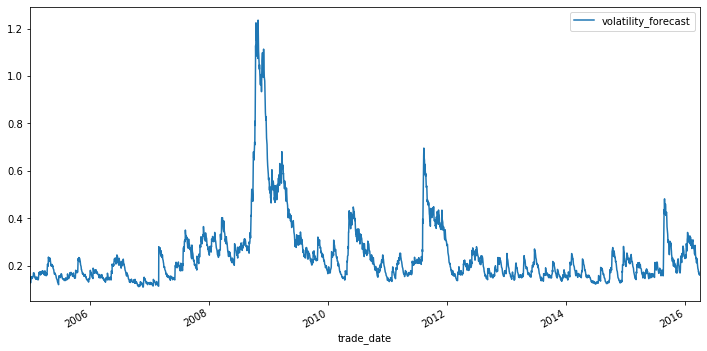

In [15]:
df_forecast.plot(x = 'trade_date', y = 'volatility_forecast', figsize = (12, 6));

We actually have far more forecasts than we need, because we calculated forecasts for each day. We can isolate the ones in question by using a join.

In [16]:
df_start_end.merge(df_forecast[['trade_date', 'volatility_forecast']], left_on = 'week_end', right_on = 'trade_date')

week_num week_start   week_end trade_date  volatility_forecast
0           0 2005-01-03 2005-01-07 2005-01-07             0.147484
1           1 2005-01-10 2005-01-14 2005-01-14             0.150797
2           2 2005-01-18 2005-01-21 2005-01-21             0.170144
3           3 2005-01-24 2005-01-28 2005-01-28             0.147868
4           4 2005-01-31 2005-02-04 2005-02-04             0.151964
..        ...        ...        ...        ...                  ...
581       581 2016-02-22 2016-02-26 2016-02-26             0.250592
582       582 2016-02-29 2016-03-04 2016-03-04             0.242542
583       583 2016-03-07 2016-03-11 2016-03-11             0.230967
584       584 2016-03-14 2016-03-18 2016-03-18             0.188826
585       585 2016-03-21 2016-03-24 2016-03-24             0.167193

[586 rows x 5 columns]

Let's grab the forecasts and put them into their own variable.

In [17]:
volatility_forecasts = df_start_end.merge(df_forecast, left_on = 'week_end', right_on = 'trade_date')['volatility_forecast']
volatility_forecasts

0      0.147484
1      0.150797
2      0.170144
3      0.147868
4      0.151964
         ...   
581    0.250592
582    0.242542
583    0.230967
584    0.188826
585    0.167193
Name: volatility_forecast, Length: 586, dtype: float64

And finally, let's use the $R^2$ metric that Sepp uses in his studies.

In [18]:
np.corrcoef(volatility_forecasts, df_realized['realized_vol'])[0,1] ** 2

0.5612550395666103

## References

*Does Anything Beat Garch(1, 1)* - Hansen and Lunde 2004

*Options, Futures, and Other Derivatives 9th Edition* - John Hull (Chapter 23)

*Volatility Modeling and Trading* - Artur Sepp 2016

https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html

## Old Code

In [19]:
# import warnings
# warnings.simplefilter('ignore')

# %matplotlib inline
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set_style('darkgrid')
# plt.rc("figure", figsize=(16, 6))
# plt.rc("savefig", dpi=90)
# plt.rc("font",family="sans-serif")
# plt.rc("font",size=14)

In [20]:
# import datetime as dt

# from arch import arch_model
# import arch.data.sp500

# data = arch.data.sp500.load()
# market = data['Adj Close']
# returns = 100 * market.pct_change().dropna()

In [21]:
# am = arch_model(returns, vol = 'Garch', p = 1, o = 0, q = 1, dist = 'Normal')
# res = am.fit(update_freq = 5)

In [22]:
#forecasts = res.forecast()

In [23]:
#type(forecasts)

In [24]:
#print(forecasts.variance)

In [25]:
#returns.iloc[-2:]

In [26]:
# index = returns.index
# start_loc = 0
# end_loc = np.where(index >= '2010-1-1')[0].min()
# forecasts = {}
# for i in range(20):
#     sys.stdout.write('.')
#     sys.stdout.flush()
#     res = am.fit(first_obs=i, last_obs=i + end_loc, disp='off')
#     temp = res.forecast(horizon=5).variance
#     fcast = temp.iloc[i + end_loc - 1]
#     forecasts[fcast.name] = fcast
# print()
# print(pd.DataFrame(forecasts).T)

In [27]:
# pd.DataFrame(forecasts).T

In [28]:
# returns

In [29]:
#variance

In [30]:
#df_forecast

In [31]:
#df_forecast['vol_estimate'] = np.sqrt(df_forecast.variance_estimate)

In [32]:
#df_train.query('trade_date >= "2005-01-01"')

In [33]:
#df_forecast.reset_index(drop = False).rename(columns = {'index':'trade_date'}).to_csv('variance_forecast.csv', index = False)

In [34]:
#df_forecast.to_csv('variance_forecast.csv', index = False)

In [35]:
#df_test = pd.read_csv('variance_forecast.csv')
#df_test

In [36]:
#df_forecast = df_forecast.reset_index().rename(columns = {'index':'trade_date'})
#df_forecast